# Email Spam Classification Using NLP and ML
Ladringan, Christine Love L. 

## Data Collection

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_email = pd.read_csv('email_spam_train.csv')
df_email = df_email[['Label', 'Body']]
df_email

,Label,Body
0,1,\nSave up to 70% on Life Insurance.\nWhy Spend...
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...
2,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...
3,1,##############################################...
4,1,I thought you might like these:\n1) Slim Down ...
...,...,...
14976,0,"Subject: monday 22 nd oct\n louise ,\n do you ..."
14977,0,Subject: missing bloomberg deals\n stephanie -...
14978,0,Subject: eops salary survey questionnaire\n we...
14979,0,"Subject: q 3 comparison\n hi louise ,\n i have..."


In [3]:
df_email.columns = ['target', 'text']

In [4]:
df_email[df_email.isnull().any(axis=1)]

,target,text
232,1,NaN


In [5]:
df_email = df_email.dropna()
df_email.isnull().sum()

target    0
text      0
dtype: int64

In [6]:
df_email.duplicated().sum()

0

## Exploratory Data Analysis

In [7]:
df_email['target'].value_counts()

0    8842
1    6138
Name: target, dtype: int64

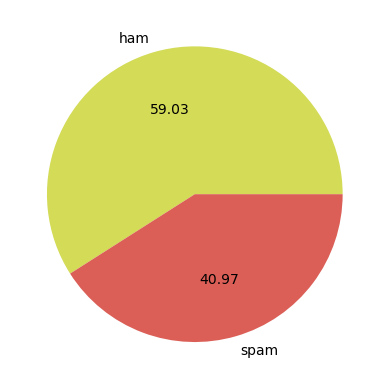

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

blue_palette = sns.color_palette("hls")
colors = [blue_palette[1], blue_palette[0]]
plt.pie(df_email['target'].value_counts(), labels=['ham', 'spam'], autopct="%0.2f", colors=colors)

plt.show()

In [9]:
df_email = df_email.copy()

In [10]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

In [11]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

def count_text_features(text):
    num_words = len(word_tokenize(text))
    num_sentences = len(sent_tokenize(text))
    num_characters = len(text)
    
    return num_words, num_sentences, num_characters

df_email[['num_words', 'num_sentences', 'num_characters']] = df_email['text'].apply(count_text_features).apply(pd.Series)

In [12]:
df_email

,target,text,num_words,num_sentences,num_characters
0,1,\nSave up to 70% on Life Insurance.\nWhy Spend...,191,12,1111
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,139,5,753
2,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,113,4,610
3,1,##############################################...,690,35,2863
4,1,I thought you might like these:\n1) Slim Down ...,108,4,641
...,...,...,...,...,...
14976,0,"Subject: monday 22 nd oct\n louise ,\n do you ...",39,2,154
14977,0,Subject: missing bloomberg deals\n stephanie -...,1806,35,7864
14978,0,Subject: eops salary survey questionnaire\n we...,330,7,1343
14979,0,"Subject: q 3 comparison\n hi louise ,\n i have...",68,5,279


In [13]:
df_email[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,14980.000000,14980.000000,14980.000000
mean,1679.921028,330.484312,14.215020
std,4432.597914,786.383305,37.269184
min,1.000000,0.000000,0.000000
25%,412.000000,82.000000,4.000000
50%,829.000000,169.000000,7.000000
75%,1649.000000,334.000000,14.000000
max,194978.000000,23345.000000,2073.000000


In [14]:
df_email[df_email['target'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,6138.000000,6138.000000,6138.000000
mean,1579.347344,301.659661,15.176442
std,3280.228668,546.284296,35.456358
min,1.000000,0.000000,0.000000
25%,405.250000,80.000000,5.000000
50%,757.500000,152.000000,9.000000
75%,1570.000000,303.000000,16.000000
max,129635.000000,13288.000000,2073.000000


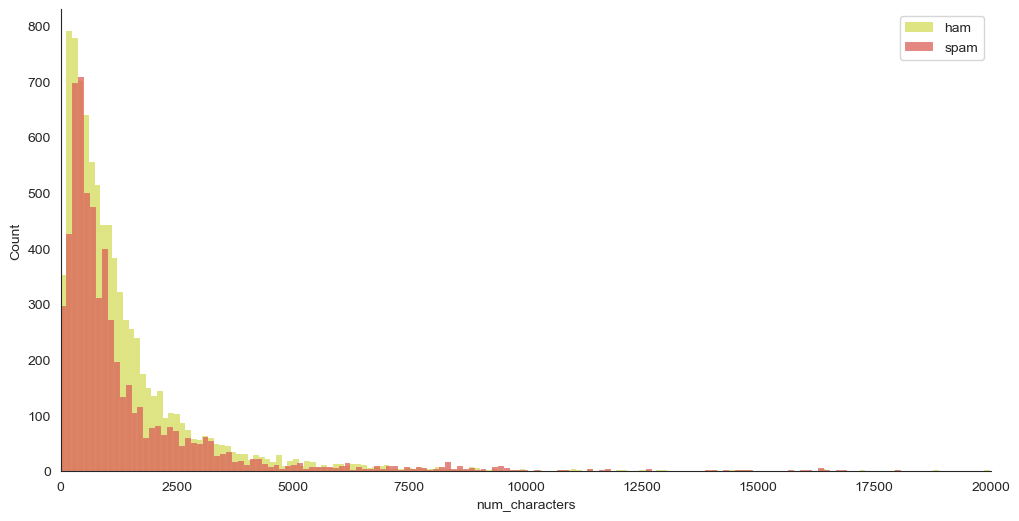

In [15]:
plt.figure(figsize=(12, 6))

sns.set_style("white")
sns.histplot(df_email[df_email['target'] == 0]['num_characters'], color=blue_palette[1], label='ham')
sns.histplot(df_email[df_email['target'] == 1]['num_characters'], color=blue_palette[0], label='spam')

plt.xlim(0, 20000)
sns.despine()

plt.legend()
plt.show()

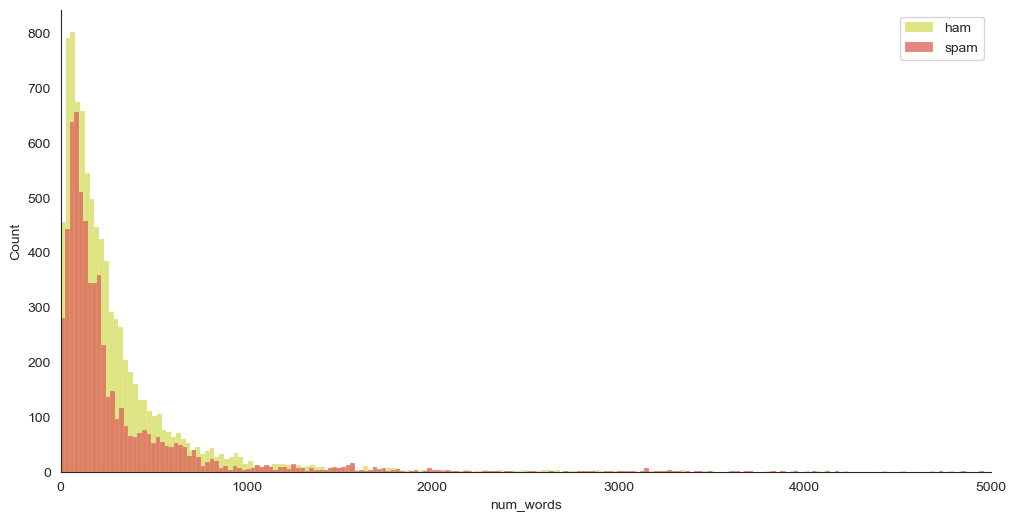

In [16]:
plt.figure(figsize=(12, 6))

sns.set_style("white")
sns.histplot(df_email[df_email['target'] == 0]['num_words'], color=blue_palette[1], label='ham')
sns.histplot(df_email[df_email['target'] == 1]['num_words'], color=blue_palette[0], label='spam')

plt.xlim(0, 5000)
sns.despine()

plt.legend()
plt.show()

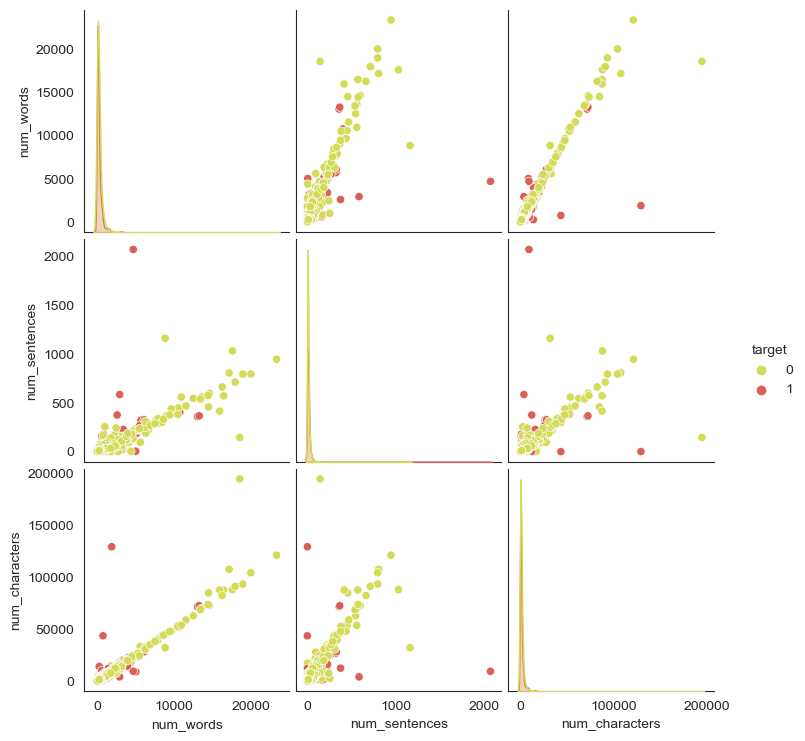

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

palette = {0: blue_palette[1], 1: blue_palette[0]}
sns.set_style("white")
sns.pairplot(df_email, hue='target', palette=palette,  plot_kws={'edgecolor': 'w'})

plt.show()

## Data Preprocessing

In [18]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/christineloveladringan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
def clean_email_body(email):
    # Convert to lowercase
    email = email.lower()
    
    # Remove subject heaaders
    email = re.sub(r'subject:.*\n', '', email)

    # Replace numbers with 'number'
    email = re.sub(r'\b\d+(\.\d+)?\b', 'number', email)
    
    # Replace dollar signs with 'dollar' 
    email = re.sub('[$]+', 'dollar', email)
    
    # Replace URLs with 'httpaddr'
    email = re.sub('(http|https)://[^\s]*', 'httpaddr', email)
    
    # Replace email addresses with 'email'
    email = re.sub('[^\s]+@[^\s]+', 'emailaddr', email)
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    email = ' '.join(word for word in email.split() if word not in stop_words)
    
    # Perform word stemming using Porter stemmer
    stemmer = SnowballStemmer('english')
    email = ' '.join(stemmer.stem(word) for word in email.split())
      
    # Remove non-words and punctuation
    email = re.sub(r'\W', ' ', email)
    
    # Trim white spaces to a single space character
    email = re.sub(r'\s+', ' ', email).strip()
    
    return email

In [20]:
df_email['text_cleaned'] = df_email['text'].apply(clean_email_body)

In [21]:
df_email

,target,text,num_words,num_sentences,num_characters,text_cleaned
0,1,\nSave up to 70% on Life Insurance.\nWhy Spend...,191,12,1111,save number life insurance spend to lif quot s...
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,139,5,753,number fight risk cancer httpaddr slim guarant...
2,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,113,4,610,number fight risk cancer httpaddr slim guarant...
3,1,##############################################...,690,35,2863,adult club offer free membership instant acces...
4,1,I thought you might like these:\n1) Slim Down ...,108,4,641,thought might like these number slim guarante ...
...,...,...,...,...,...,...
14976,0,"Subject: monday 22 nd oct\n louise ,\n do you ...",39,2,154,louis half hour free diari number number see w...
14977,0,Subject: missing bloomberg deals\n stephanie -...,1806,35,7864,stephani believ found trade first one alreadi ...
14978,0,Subject: eops salary survey questionnaire\n we...,330,7,1343,need establish deadlin friday march number th ...
14979,0,"Subject: q 3 comparison\n hi louise ,\n i have...",68,5,279,hi louis comparison first two week q number st...


## Feature Engineering

In [22]:
import re

def count_pattern_occurrences(email, pattern):
    occurrences = re.findall(pattern, email)
    return len(occurrences)

df_email['num_httpaddr'] = df_email['text_cleaned'].apply(lambda x: count_pattern_occurrences(x, 'httpaddr'))
df_email['num_emailaddr'] = df_email['text_cleaned'].apply(lambda x: count_pattern_occurrences(x, 'emailaddr'))
df_email['num_number'] = df_email['text_cleaned'].apply(lambda x: count_pattern_occurrences(x, 'number'))
df_email['num_dollar'] = df_email['text_cleaned'].apply(lambda x: count_pattern_occurrences(x, 'dollar'))

In [23]:
def count_punct(text: str):
    return len(re.findall('[^\w\s]', text))

df_email['num_punct'] = df_email['text'].apply(count_punct)

In [24]:
df_email

,target,text,num_words,num_sentences,num_characters,text_cleaned,num_httpaddr,num_emailaddr,num_number,num_dollar,num_punct
0,1,\nSave up to 70% on Life Insurance.\nWhy Spend...,191,12,1111,save number life insurance spend to lif quot s...,0,0,3,1,24
1,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,139,5,753,number fight risk cancer httpaddr slim guarant...,7,2,3,0,100
2,1,1) Fight The Risk of Cancer!\nhttp://www.adcli...,113,4,610,number fight risk cancer httpaddr slim guarant...,6,0,3,0,81
3,1,##############################################...,690,35,2863,adult club offer free membership instant acces...,6,1,15,1,448
4,1,I thought you might like these:\n1) Slim Down ...,108,4,641,thought might like these number slim guarante ...,5,2,4,0,75
...,...,...,...,...,...,...,...,...,...,...,...
14976,0,"Subject: monday 22 nd oct\n louise ,\n do you ...",39,2,154,louis half hour free diari number number see w...,0,0,2,0,6
14977,0,Subject: missing bloomberg deals\n stephanie -...,1806,35,7864,stephani believ found trade first one alreadi ...,0,0,249,5,585
14978,0,Subject: eops salary survey questionnaire\n we...,330,7,1343,need establish deadlin friday march number th ...,0,0,11,0,127
14979,0,"Subject: q 3 comparison\n hi louise ,\n i have...",68,5,279,hi louis comparison first two week q number st...,0,0,2,0,11


## Machine Learning Modelling

In [25]:
df_email.columns

Index(['target', 'text', 'num_words', 'num_sentences', 'num_characters',
       'text_cleaned', 'num_httpaddr', 'num_emailaddr', 'num_number',
       'num_dollar', 'num_punct'],
      dtype='object')

In [26]:
X_train = df_email[['text_cleaned', 'num_httpaddr', 'num_emailaddr', 'num_dollar', 'num_punct']]
y_train = df_email['target'].to_numpy()

In [27]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer

tfidf_vectorizer = TfidfVectorizer(max_features=1000)

In [28]:
vectorizer = TfidfVectorizer()
col_transformer = ColumnTransformer([('vct', vectorizer, 'text_cleaned')], remainder='passthrough')

X_train_transformed = col_transformer.fit_transform(X_train)

In [29]:
X_train = X_train_transformed.toarray()
X_train

array([[  0.,   0.,   0., ...,   0.,   1.,  24.],
       [  0.,   0.,   0., ...,   2.,   0., 100.],
       [  0.,   0.,   0., ...,   0.,   0.,  81.],
       ...,
       [  0.,   0.,   0., ...,   0.,   0., 127.],
       [  0.,   0.,   0., ...,   0.,   0.,  11.],
       [  0.,   0.,   0., ...,   0.,   0.,  43.]])

In [30]:
X_train.shape

(14980, 102351)

In [31]:
y_train

array([1, 1, 1, ..., 0, 0, 0])

In [32]:
y_train.shape

(14980,)

## Classifier Evaluation

In [33]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def eval_confusion(y_pred, y_true=y_train):
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return {'matrix': conf_matrix, 'precision': precision, 'recall': recall, 'f1': f1}

In [34]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

classifiers = {
    'MultinomialNB': MultinomialNB(),
    'SVM': SVC(),
    'RandomForest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'KNN': KNeighborsClassifier()
}

In [35]:
from sklearn.model_selection import cross_val_predict, StratifiedKFold

y_preds = {}
for clf_name, clf in classifiers.items():
    y_preds[clf_name] = cross_val_predict(clf, X_train_transformed, y_train, cv=3)

Stratified kfold cross validation was employed.

In [36]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
np.random.seed(42)

y_preds = {}
for clf_name, clf in classifiers.items():
    y_preds[clf_name] = cross_val_predict(clf, X_train_transformed, y_train, cv=stratified_kfold)

for clf_name, y_pred in y_preds.items():
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred)
    recall = recall_score(y_train, y_pred)
    f1 = f1_score(y_train, y_pred)

    print(f"{clf_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1 Score: {f1:.4f}")
    print("\n")

MultinomialNB:
  Accuracy: 0.8122
  Precision: 0.9798
  Recall: 0.5531
  F1 Score: 0.7071


SVM:
  Accuracy: 0.5937
  Precision: 0.6940
  Recall: 0.0152
  F1 Score: 0.0297


RandomForest:
  Accuracy: 0.9697
  Precision: 0.9705
  Recall: 0.9550
  F1 Score: 0.9627


XGBoost:
  Accuracy: 0.9666
  Precision: 0.9482
  Recall: 0.9715
  F1 Score: 0.9597


KNN:
  Accuracy: 0.7878
  Precision: 0.7682
  Recall: 0.6905
  F1 Score: 0.7272




The reported results suggest that the **Random Forest (RF) classifier** performed very well on the training dataset based on the cross-validation evaluation. 

* **Accuracy:** It achieved an accuracy of 96.97%, meaning that approximately 96.97% of the instances in the dataset were correctly classified by the model.

* **Precision**: A precision of 97.05% indicates that when the RF classifier predicts a positive class, it is correct about 97.05% of the time.

* **Recall:** Suggests that the model identified approximately 95.50% of all actual positive instances.

* **F1 Score:** The value of 0.9627 implies a good balance between precision and recall. This is a useful metric when there is an uneven class distribution.

## Best Model

In [37]:
best_model = RandomForestClassifier()
best_model.fit(X_train_transformed, y_train)

RandomForestClassifier()

#### Saving model as `pickle`

In [38]:
import pickle

model_filename = 'best_model.pkl'

with open(model_filename, 'wb') as model_file:
    pickle.dump(best_model, model_file)

Download model file here: https://drive.google.com/file/d/1dsB_QNZoJZgCIJwsTSYk0KiyqcRaAgKB/view?usp=sharing

#### Loading `pickle` file 

In [39]:
with open(model_filename, 'rb') as model_file:
    loaded_model = pickle.load(model_file)

#### Sample test data

Make sure to change `sample_test.csv` to actual csv containing test data form email spams.

Also, the codes below are in Raw NBConvert. Convert it to codes for it be run.